# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

## Trajetória de um projeto em Data Science

1. Entendimento do desafio que queremos resolver
2. Entendimento da Empresa/Área
3. Extração/obtenção de dados
4. Ajustes de dados (Limpeza de dados)
5. Análise exploratória
6. Modelagem + algoritmos
7. Interpretação dos resultados
8. Deploy/produção

## Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

## Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

## O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

## Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

# Importar Bibliotecas e Bases de Dados

In [96]:
import pandas as pd
import pathlib
import calendar
import re
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import joblib

from zipfile import ZipFile
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

## Funções

In [2]:
def month_filename(filename):
    month = 0
    year = 0
    if filename[:3] in meses.keys():
        month = meses[filename[:3]]
        year = int(filename[-8:(len(filename)-4)]) #.csv files
    return(month, year)

In [3]:
def multiple_zips_get_months(zippedFile, dataframe = pd.DataFrame(), file_type = '.csv', low_memory = False):
    for i, text_file in enumerate(zippedFile.infolist()):
        if (text_file.filename.endswith(file_type)):
            # show progress
            print('{}/{} ({:.0%}) >> {}'.format((i+1), len(zip_file.infolist()),
                                (i+1)/len(zip_file.infolist()),
                                 text_file.filename))
            # read file
            file = pd.read_csv(zippedFile.open(text_file.filename), low_memory= low_memory)
             
            # add month and year
            just_filename = re.findall(re.compile(r'/(.+)'),text_file.filename)[0]
            mes, ano = month_filename(just_filename)
            file['mes'] = mes
            file['ano'] = ano
            
            # concat files
            dataframe = pd.concat([dataframe, file])
    return dataframe

In [81]:
def dois_boxplots(coluna):
    # subplot
    fig, (ax1, ax2) = plt.subplots(1,2)
    
    # tamanho da figura
    fig.set_size_inches(15, 5)
    
    # boxplot dos dados 
    sns.boxplot(x = coluna, ax= ax1)
    
    # boxplot sem outliers
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x = coluna, ax= ax2)

def histogramas(coluna):
    #tamanho da figura
    plt.figure(figsize = (15,5))
    
    #histograma
    sns.distplot(x=coluna)
    
def grafico_barras(coluna, remove_outliers = True):
    #tamanho da figura
    plt.figure(figsize = (15,5))
    
    #histograma
    ax = sns.barplot(x=coluna.value_counts().index, y= coluna.value_counts())
    
    if remove_outliers:
        # boxplot sem outliers
        ax.set_xlim(limites(coluna))
        
def count_plot(col, data = base_airbnb):
    print(base_airbnb[col].value_counts())
    plt.figure(figsize = (15,5))
    grafico = sns.countplot(col, data)
    grafico.tick_params(axis= 'x', rotation = 80)

## Meses (em pt)

In [5]:
# to portuguese
meses = {month: index for index, month in enumerate(calendar.month_abbr) if month}
meses = {'Fev' if k == 'Feb'
         else 'Abr' if k == 'Apr' 
         else 'Mai' if k == 'May'
         else 'Ago' if k == 'Aug'
         else 'Set' if k == 'Sep'
         else 'Out' if k == 'Oct'
         else 'Dez' if k == 'Dec'
         else k:v for k,v in meses.items()}
meses = {k.lower(): v for k, v in meses.items()}
meses.keys() 

dict_keys(['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez'])

## Diretório

In [6]:
caminho = pathlib.Path(r'../../PYTHON/HASHTAG/data/')
zipped_file = pathlib.Path(r'dataset - projeto ds.zip')
zip_file = ZipFile(caminho / zipped_file)
zip_file

<zipfile.ZipFile filename='..\\..\\PYTHON\\HASHTAG\\data\\dataset - projeto ds.zip' mode='r'>

# Lendo dados

In [7]:
base_airbnb_raw = multiple_zips_get_months(zip_file)

1/25 (4%) >> dataset/abril2018.csv
2/25 (8%) >> dataset/abril2019.csv
3/25 (12%) >> dataset/abril2020.csv
4/25 (16%) >> dataset/agosto2018.csv
5/25 (20%) >> dataset/agosto2019.csv
6/25 (24%) >> dataset/dezembro2018.csv
7/25 (28%) >> dataset/dezembro2019.csv
8/25 (32%) >> dataset/fevereiro2019.csv
9/25 (36%) >> dataset/fevereiro2020.csv
10/25 (40%) >> dataset/janeiro2019.csv
11/25 (44%) >> dataset/janeiro2020.csv
12/25 (48%) >> dataset/julho2018.csv
13/25 (52%) >> dataset/julho2019.csv
14/25 (56%) >> dataset/junho2019.csv
15/25 (60%) >> dataset/maio2018.csv
16/25 (64%) >> dataset/maio2019.csv
17/25 (68%) >> dataset/maio2020.csv
18/25 (72%) >> dataset/maro2019.csv
19/25 (76%) >> dataset/maro2020.csv
20/25 (80%) >> dataset/novembro2019.csv
21/25 (84%) >> dataset/novrmbro2018.csv
22/25 (88%) >> dataset/outubro2018.csv
23/25 (92%) >> dataset/outubro2019.csv
24/25 (96%) >> dataset/setembro2018.csv
25/25 (100%) >> dataset/setembro2019.csv


In [8]:
base_airbnb = base_airbnb_raw.copy()

In [9]:
base_airbnb.shape

(902210, 108)

In [10]:
base_airbnb.head(3)

id                         listing_url       scrape_id last_scraped  \
0  14063  https://www.airbnb.com/rooms/14063  20180414160018   2018-04-14   
1  17878  https://www.airbnb.com/rooms/17878  20180414160018   2018-04-14   
2  24480  https://www.airbnb.com/rooms/24480  20180414160018   2018-04-14   

                                name  \
0               Living in a Postcard   
1  Very Nice 2Br - Copacabana - WiFi   
2   Nice and cozy near Ipanema Beach   

                                             summary  \
0  Besides the most iconic's view, our apartment ...   
1  Please note that special rates apply for New Y...   
2  My studio is located in the best  of Ipanema. ...   

                                               space  \
0                                                NaN   
1  - large balcony which looks out on pedestrian ...   
2  The studio is located at Vinicius de Moraes St...   

                                         description experiences_offered  \
0  Besides the most iconic's view, our apartment ...                none   
1  Please note that special rates apply for New Y...                none   
2  My studio is located in the best  of Ipanema. ...                none   

                               neighborhood_overview  ...  \
0  Best and favorite neighborhood of Rio. Perfect...  ...   
1  This is the best spot in Rio. Everything happe...  ...   
2  The beach, the lagoon, Ipanema is a great loca...  ...   

  minimum_minimum_nights maximum_minimum_nights minimum_maximum_nights  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   

  maximum_maximum_nights minimum_nights_avg_ntm  maximum_nights_avg_ntm  \
0                    NaN                    NaN                     NaN   
1                    NaN                    NaN                     NaN   
2                    NaN                    NaN                     NaN   

   number_of_reviews_ltm calculated_host_listings_count_entire_homes  \
0                    NaN                                         NaN   
1                    NaN                                         NaN   
2                    NaN                                         NaN   

   calculated_host_listings_count_private_rooms  \
0                                           NaN   
1                                           NaN   
2                                           NaN   

   calculated_host_listings_count_shared_rooms  
0                                          NaN  
1                                          NaN  
2                                          NaN  

[3 rows x 108 columns]

# Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

<font color = 'green'>Pode ser interessante acrescentar mais colunas, como um len() da descrição do local.
    <br >Talvez apartamentos melhores descritos sejam mais atrativos </font>

In [11]:
select_colunas = ['host_response_time',
                  'host_response_rate',
                  'host_is_superhost',
                  'host_listings_count',
                  'latitude',
                  'longitude',
                  'property_type',
                  'room_type',
                  'accommodates',
                  'bathrooms',
                  'bedrooms',
                  'beds',
                  'bed_type',
                  'amenities',
                  'price',
                  'security_deposit',
                  'cleaning_fee',
                  'guests_included',
                  'extra_people',
                  'minimum_nights',
                  'maximum_nights',
                  'number_of_reviews',
                  'review_scores_rating',
                  'review_scores_accuracy',
                  'review_scores_cleanliness',
                  'review_scores_checkin',
                  'review_scores_communication',
                  'review_scores_location',
                  'review_scores_value',
                  'instant_bookable',
                  'is_business_travel_ready',
                  'cancellation_policy',
                  'ano',
                  'mes']

In [12]:
base_airbnb = base_airbnb.loc[:, select_colunas]
base_airbnb.head(2)

host_response_time host_response_rate host_is_superhost  \
0                NaN                NaN                 f   
1     within an hour               100%                 t   

   host_listings_count   latitude  longitude property_type        room_type  \
0                  1.0 -22.946854 -43.182737     Apartment  Entire home/apt   
1                  2.0 -22.965919 -43.178962   Condominium  Entire home/apt   

   accommodates  bathrooms  ...  review_scores_cleanliness  \
0             4        1.0  ...                        9.0   
1             5        1.0  ...                        9.0   

   review_scores_checkin review_scores_communication review_scores_location  \
0                    9.0                         9.0                    9.0   
1                   10.0                        10.0                    9.0   

  review_scores_value instant_bookable is_business_travel_ready  \
0                 9.0                f                        f   
1                 9.0                t                        f   

           cancellation_policy   ano  mes  
0  strict_14_with_grace_period  2018    4  
1                       strict  2018    4  

[2 rows x 34 columns]

# Tratar Valores Faltando

In [13]:
print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [14]:
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis= 1)
print(base_airbnb.isnull().sum())

host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


# Verificar Tipos de Dados em cada coluna

In [15]:
print(base_airbnb.dtypes)
print('-'*100)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
----------------------------------------------------------------------------------------------------
host_is_superhost                                        

In [16]:
# mudando os tipos de price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
base_airbnb['price'] = base_airbnb['price'].astype(np.float32 # float32 ocupa menos espaço na memória
                                      ,copy = False) # vai mudar esse objeto pandas, não vai criar uma cópia 


C:\Users\Caroline\AppData\Local\Temp\ipykernel_30064\906598212.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')


In [17]:
# mudando os tipos de extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32 # float32 ocupa menos espaço na memória
                                      ,copy = False) # vai mudar esse objeto pandas, não vai criar uma cópia 

C:\Users\Caroline\AppData\Local\Temp\ipykernel_30064\3712765058.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')


In [18]:
base_airbnb.shape

(902210, 23)

# Análise Exploratória e Tratar Outliers

pegar texto de outliers

## Colunas numéricas contínuas

In [19]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3-q1
    return q1-(1.5*amplitude), q3+(1.5*amplitude)

def excluir_outliers(df, col):
    # linhas do df 
    qtd_linhas = df.shape[0]
    
    # identificar outliers
    lim_inf, lim_sup = limites(df[col])
    
    # remover outliers
    df = df.loc[(df[col]>= lim_inf) & (df[col]<= lim_sup), :]
    
    # diferença de linhas do df sem outliers 
    linhas_removidas = qtd_linhas - df.shape[0]
    
    return df, linhas_removidas

<AxesSubplot:>

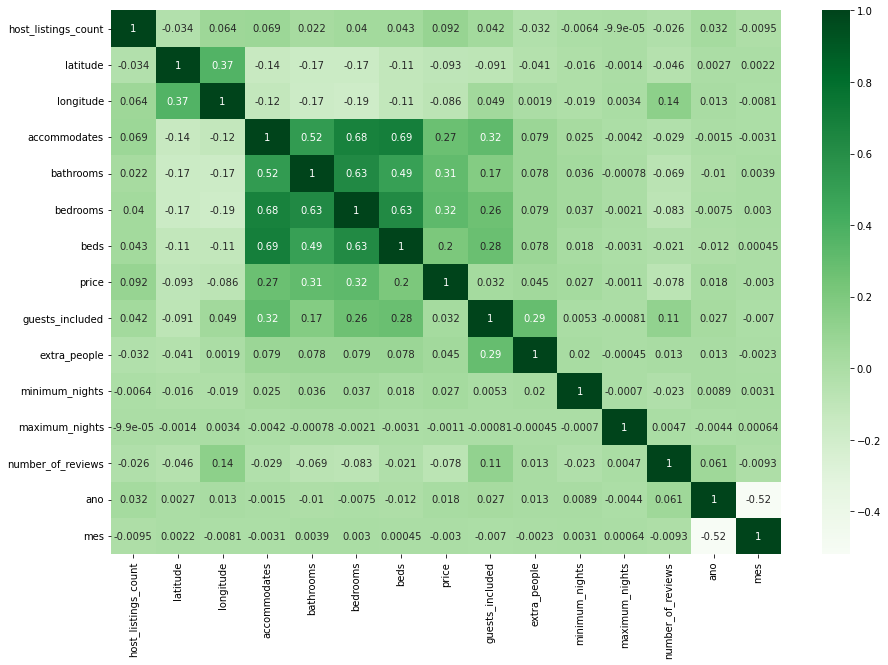

In [20]:
plt.figure(figsize = (15, 10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap = 'Greens')

In [21]:
base_airbnb, v = excluir_outliers(base_airbnb, 'price')
print('Shape {:,}\nLinhas removidas {:,}'.format(base_airbnb.shape[0], v))

Shape 814,635
Linhas removidas 87,575


In [22]:
base_airbnb, v = excluir_outliers(base_airbnb, 'extra_people')
print('Shape {:,}\nLinhas removidas {:,}'.format(base_airbnb.shape[0], v))

Shape 755,262
Linhas removidas 59,373


In [23]:
base_airbnb.price.describe()

count    755262.000000
mean        343.733215
std         279.858154
min           0.000000
25%         147.000000
50%         249.000000
75%         452.000000
max        1276.000000
Name: price, dtype: float64

In [24]:
limites(base_airbnb.price)

(-310.5, 909.5)

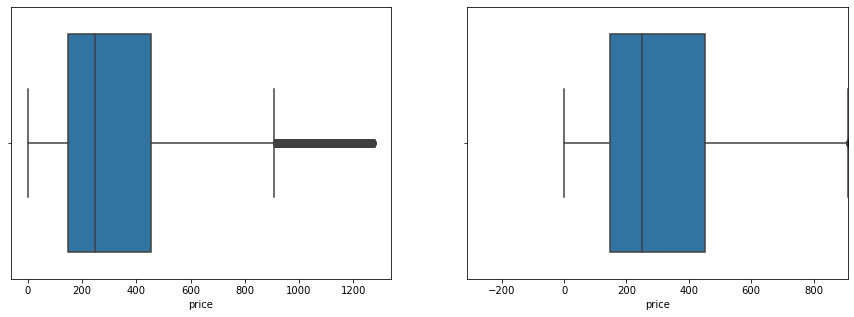

In [25]:
dois_boxplots(base_airbnb['price'])

C:\Users\Caroline\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


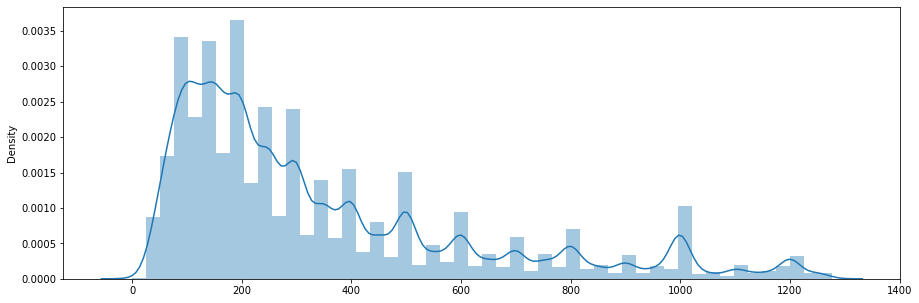

In [26]:
histogramas(base_airbnb['price'])

## Colunas numéricas discretas

### host_listings_count

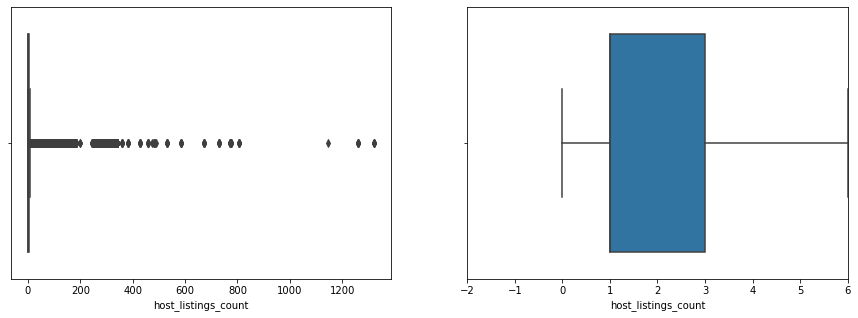

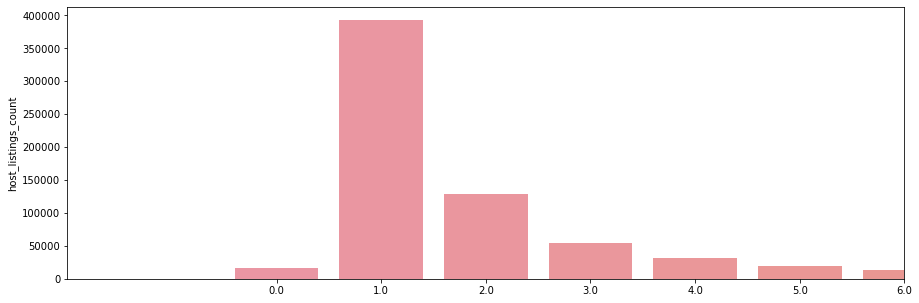

In [27]:
dois_boxplots(base_airbnb['host_listings_count'])
grafico_barras(base_airbnb['host_listings_count'])

Os outliers de host_listing counts serão removidos para adequar o modelo a casos de usuários comuns - não possuem +6 imóveis.

In [28]:
base_airbnb, v = excluir_outliers(base_airbnb, 'host_listings_count')
print('Shape {:,}\nLinhas removidas {:,}'.format(base_airbnb.shape[0], v))

Shape 656,513
Linhas removidas 98,749


### bathrooms

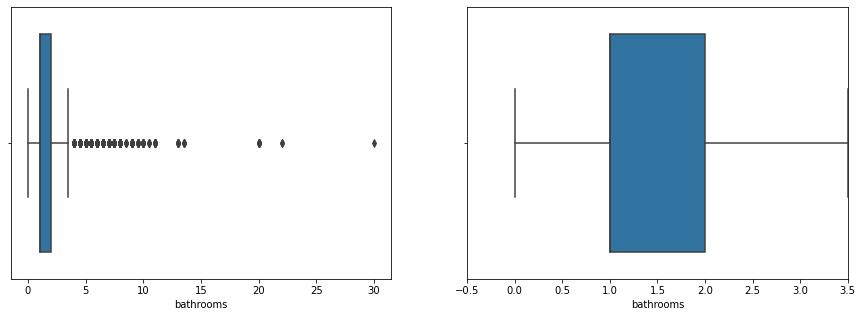

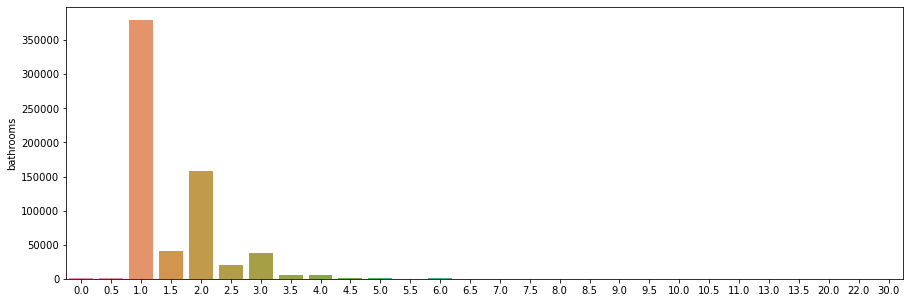

In [29]:
dois_boxplots(base_airbnb['bathrooms'])
grafico_barras(base_airbnb['bathrooms'], remove_outliers=False)

In [30]:
base_airbnb, v = excluir_outliers(base_airbnb, 'bathrooms')
print('Shape {:,}\nLinhas removidas {:,}'.format(base_airbnb.shape[0], v))

Shape 644,447
Linhas removidas 12,066


### accommodates

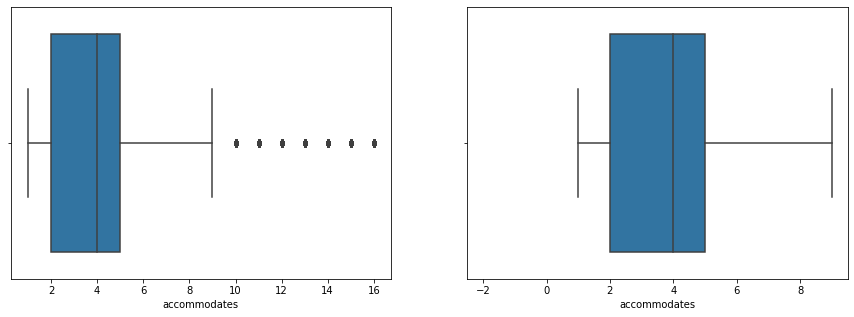

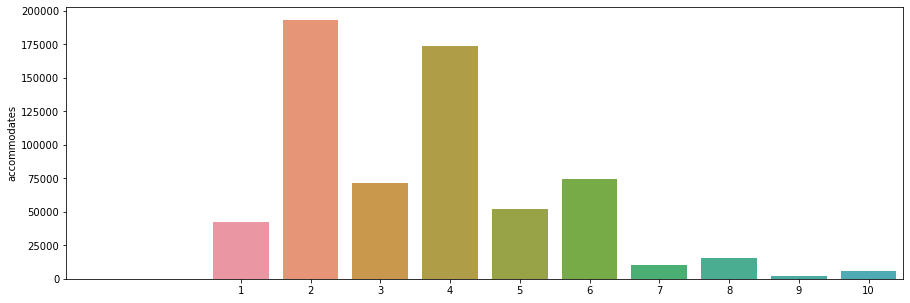

In [31]:
dois_boxplots(base_airbnb['accommodates'])
grafico_barras(base_airbnb['accommodates'])

In [32]:
base_airbnb, v = excluir_outliers(base_airbnb, 'accommodates')
print('Shape {:,}\nLinhas removidas {:,}'.format(base_airbnb.shape[0], v))

Shape 635,199
Linhas removidas 9,248


### bedrooms

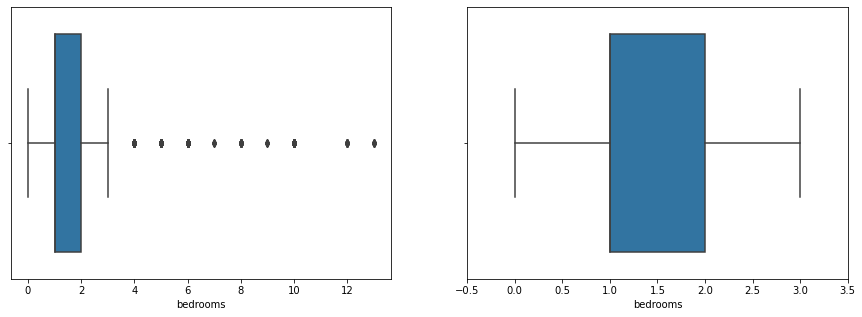

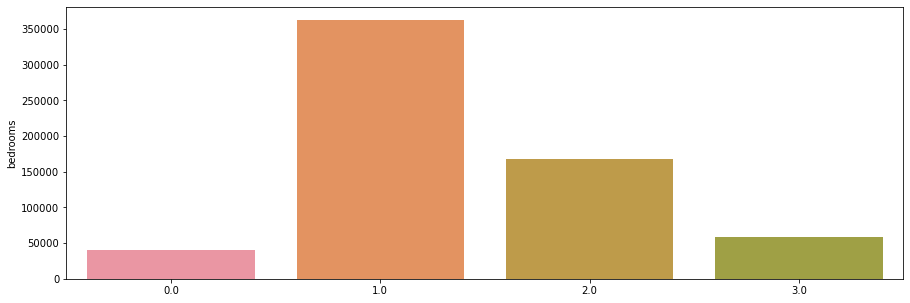

In [33]:
dois_boxplots(base_airbnb['bedrooms'])
grafico_barras(base_airbnb['bedrooms'])

In [34]:
base_airbnb, v = excluir_outliers(base_airbnb, 'bedrooms')
print('Shape {:,}\nLinhas removidas {:,}'.format(base_airbnb.shape[0], v))

Shape 629,156
Linhas removidas 6,043


### beds

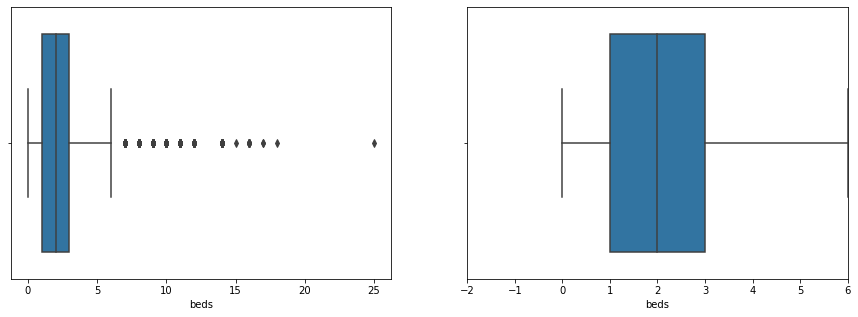

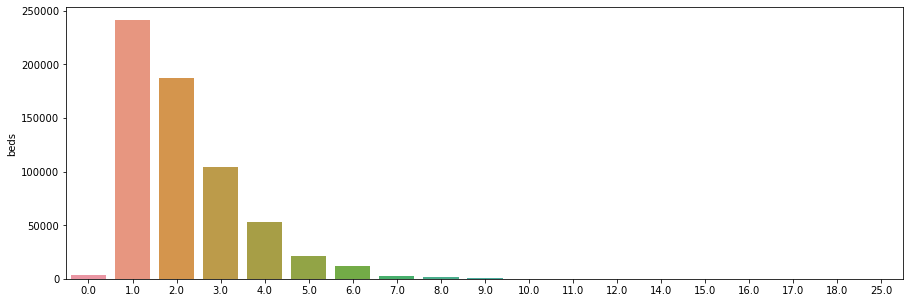

In [35]:
dois_boxplots(base_airbnb['beds'])
grafico_barras(base_airbnb['beds'], remove_outliers=False)

In [36]:
base_airbnb, v = excluir_outliers(base_airbnb, 'beds')
print('Shape {:,}\nLinhas removidas {:,}'.format(base_airbnb.shape[0], v))

Shape 622,366
Linhas removidas 6,790


### guests_included 

C:\Users\Caroline\AppData\Local\Temp\ipykernel_30064\2677818801.py:12: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax2.set_xlim(limites(coluna))


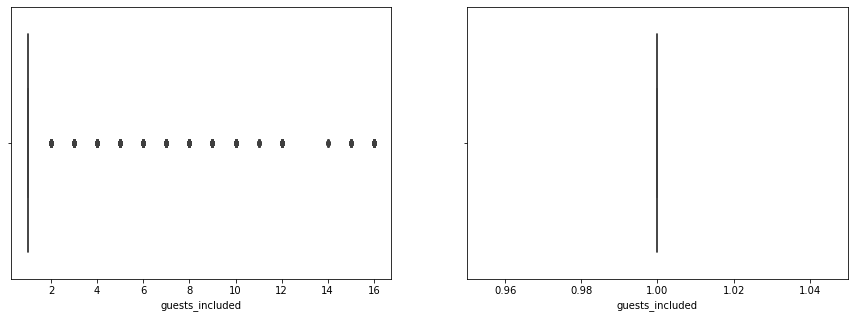

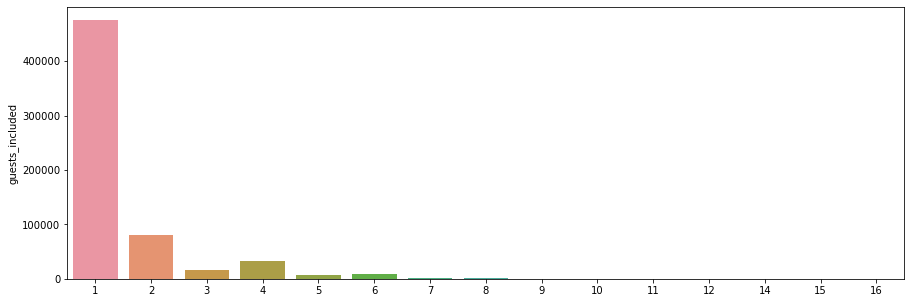

In [37]:
dois_boxplots(base_airbnb['guests_included'])
grafico_barras(base_airbnb['guests_included'], remove_outliers=False)

In [38]:
print('Limites inf e sup{}'.format(limites(base_airbnb['guests_included'])))

Limites inf e sup(1.0, 1.0)


Uma vez que se retirarmos os outliers de guests_inclueded ficamos com somente um valor (1), a variável não apresentaria variabilidade e assim não seria interessante no modelo. <br>
Neste caso, seria manter os outliers ou excluir a coluna da análise.<br>
Optamos por remover a coluna.

In [39]:
base_airbnb = base_airbnb.drop('guests_included', axis = 1)
base_airbnb.shape

(622366, 22)

### minimum_nights

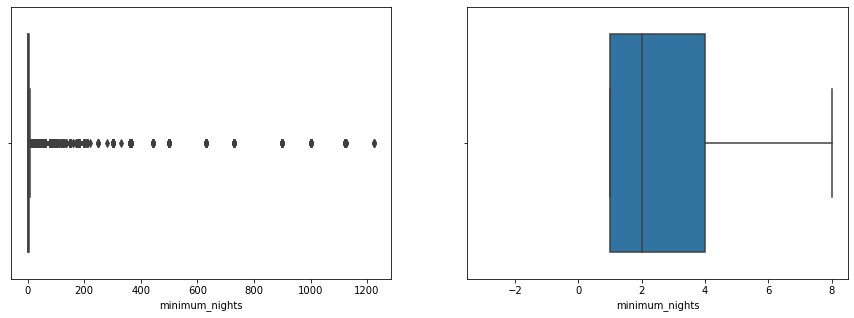

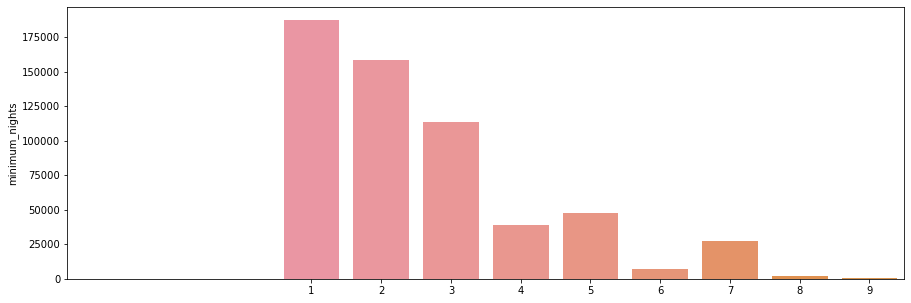

In [40]:
dois_boxplots(base_airbnb['minimum_nights'])
grafico_barras(base_airbnb['minimum_nights'])

In [41]:
base_airbnb, v = excluir_outliers(base_airbnb, 'minimum_nights')
print('Shape {:,}\nLinhas removidas {:,}'.format(base_airbnb.shape[0], v))

Shape 581,983
Linhas removidas 40,383


### maximum_nights

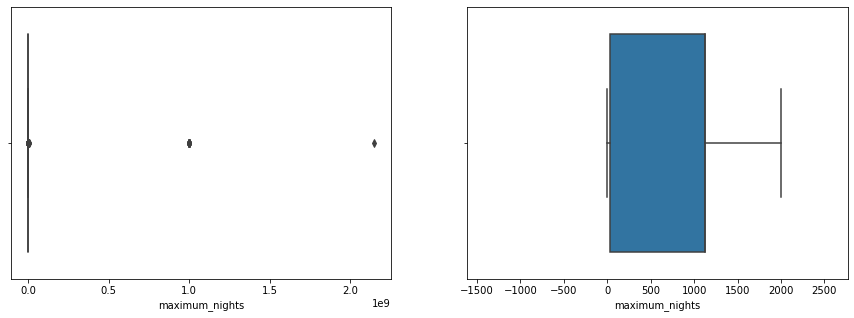

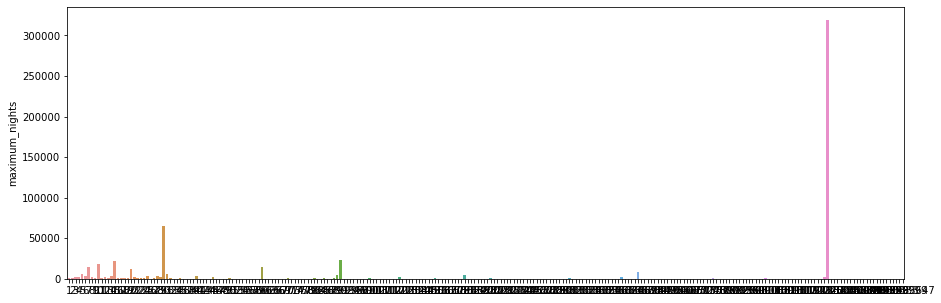

In [42]:
dois_boxplots(base_airbnb['maximum_nights'])
grafico_barras(base_airbnb['maximum_nights'], remove_outliers=False)

A coluna de maximum nights permite mais noites do que é o objetivo do modelo prever. Por isso, será removida.

In [43]:
base_airbnb = base_airbnb.drop('maximum_nights', axis = 1)
base_airbnb.shape

(581983, 21)

### number_of_reviews

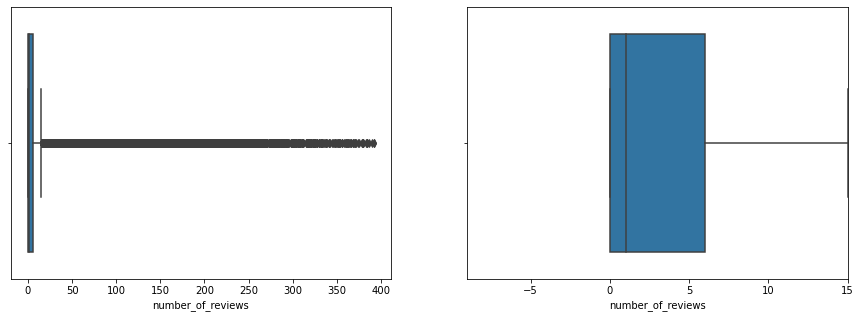

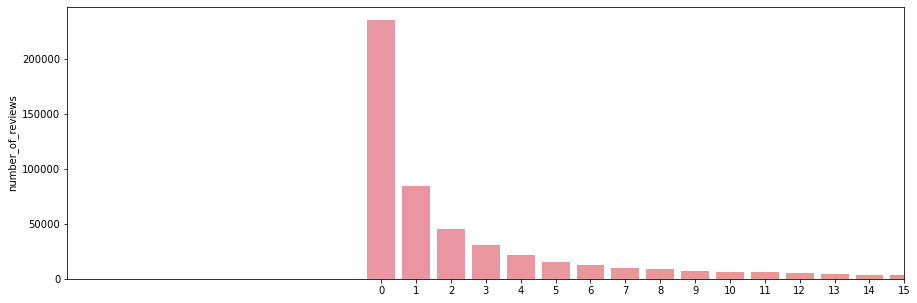

In [44]:
dois_boxplots(base_airbnb['number_of_reviews'])
grafico_barras(base_airbnb['number_of_reviews'])

A coluna de number_of_reviews será removida. <br>
Uma vez que o objetivo do modelo é prever o valor de um preço para um imóvel que ainda não está na plataforma do AirBnb, trazer o number_of_reviews poderia impactar no valor do preço. Um novo usuário não teria um valor a preencher nesse number_of_reviews.

In [45]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis= 1)
base_airbnb.shape

(581983, 20)

## Colunas categóricas

### property_type

In [46]:
base_airbnb['property_type'].value_counts()

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

In [47]:
others_property_types = [col 
         for col in base_airbnb['property_type'].value_counts().index
         if base_airbnb.loc[base_airbnb['property_type'] == col, 'property_type'].shape[0]<=2000]

base_airbnb['property_type'] = ['Other' 
                               if col in others_property_types else col
                               for col in base_airbnb['property_type']]

In [48]:
base_airbnb['property_type'].value_counts()

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Other                   8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Other                   8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


C:\Users\Caroline\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


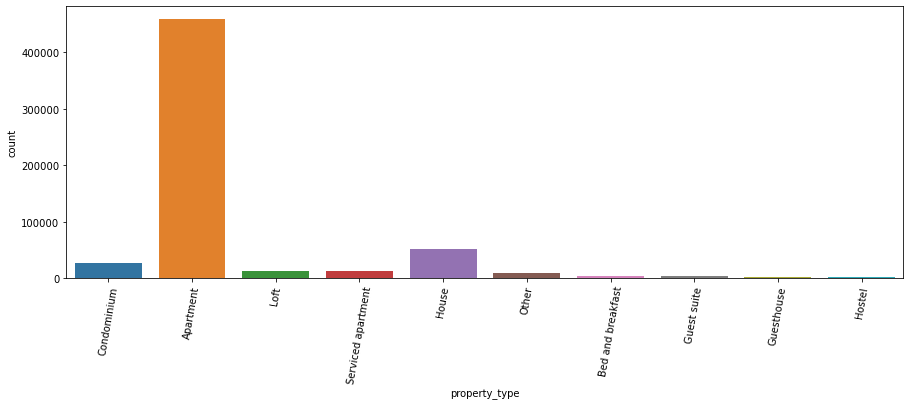

In [49]:
count_plot('property_type')

### room_type

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


C:\Users\Caroline\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


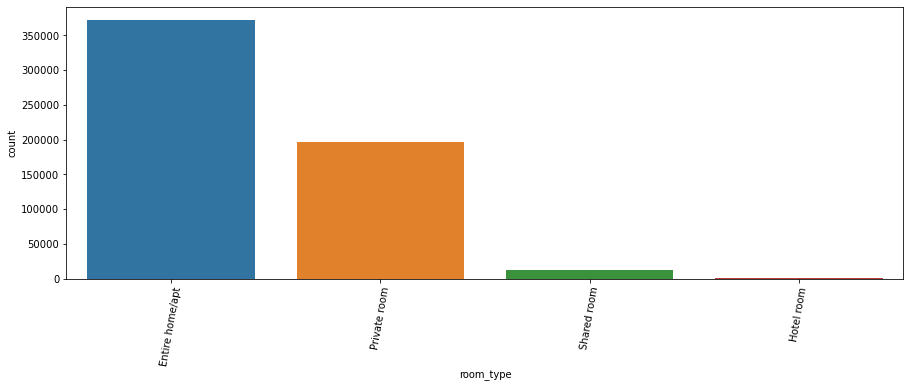

In [50]:
count_plot('room_type')

### bed_type

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


C:\Users\Caroline\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


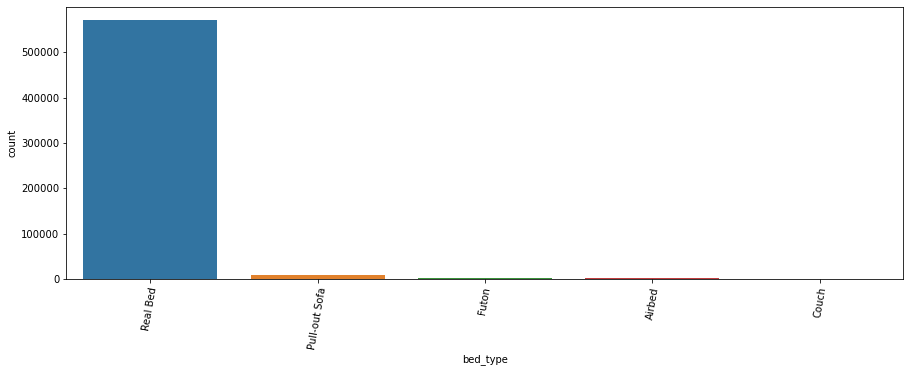

In [51]:
count_plot('bed_type')

Real Bed    570643
Others       11340
Name: bed_type, dtype: int64


C:\Users\Caroline\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


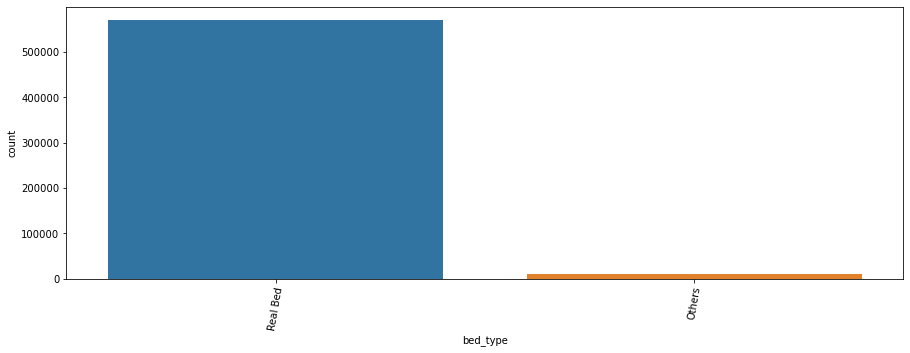

In [52]:
# agrupando valores
base_airbnb['bed_type'] = np.where(base_airbnb['bed_type'] != 'Real Bed', 'Others', base_airbnb['bed_type'])
count_plot('bed_type')

### cancellation_policy

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


C:\Users\Caroline\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


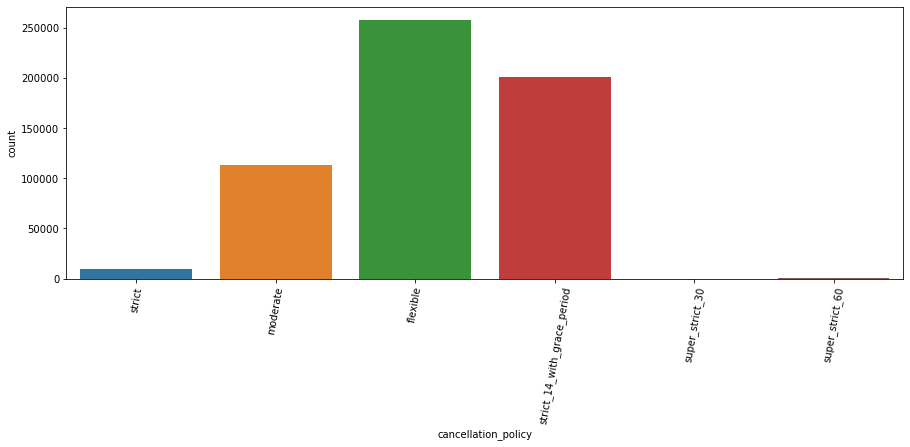

In [53]:
count_plot('cancellation_policy')

In [54]:
base_airbnb['cancellation_policy'].value_counts().index

Index(['flexible', 'strict_14_with_grace_period', 'moderate', 'strict',
       'super_strict_60', 'super_strict_30'],
      dtype='object')

In [55]:
cancellation_strict = [cat 
                       for cat in base_airbnb['cancellation_policy'].value_counts().index
                       if base_airbnb[base_airbnb['cancellation_policy'] == cat].shape[0]< 10000]
cancellation_strict

['strict', 'super_strict_60', 'super_strict_30']

In [56]:
base_airbnb['cancellation_policy'] = ['strict'
                                     if cat in cancellation_strict else cat
                                     for cat in base_airbnb['cancellation_policy'].tolist()]

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64


C:\Users\Caroline\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


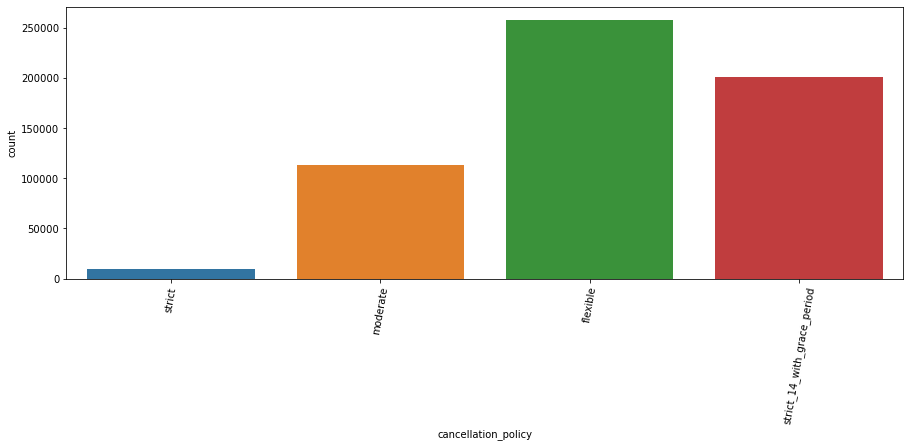

In [57]:
count_plot('cancellation_policy')

### amenities

Iremos verificar a quantidade de amenities que um imóvel possui

In [58]:
base_airbnb['nr_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)
base_airbnb['nr_amenities'].value_counts()

12    33569
13    33012
11    32982
14    32473
15    31153
      ...  
75        6
77        5
72        5
79        2
71        2
Name: nr_amenities, Length: 78, dtype: int64

In [59]:
base_airbnb = base_airbnb.drop('amenities', axis = 1)
base_airbnb.shape

(581983, 20)

#### nr_amenities outliers

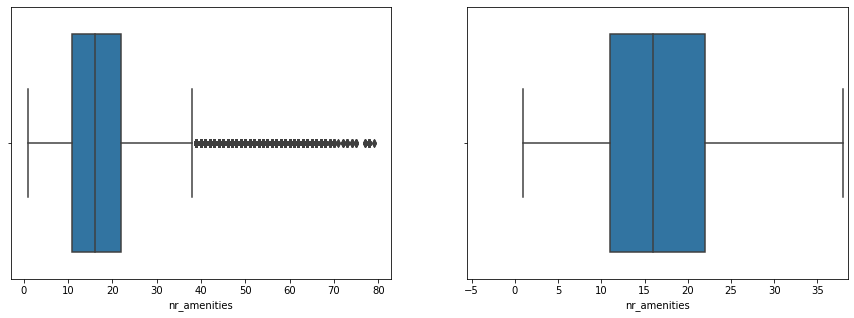

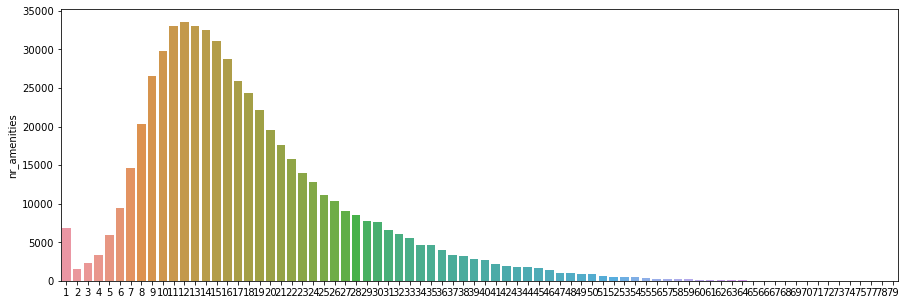

In [60]:
dois_boxplots(base_airbnb['nr_amenities'])
grafico_barras(base_airbnb['nr_amenities'], remove_outliers=False)

In [61]:
base_airbnb, v = excluir_outliers(base_airbnb, 'nr_amenities')
print('Shape {:,}\nLinhas removidas {:,}'.format(base_airbnb.shape[0], v))

Shape 557,640
Linhas removidas 24,343


## Mapa

In [62]:
#gerar uma amostra aleatória para facilitar a visualização
amostra = base_airbnb.sample(n = 50000)

# variáveis espaciais
centro_mapa = {'lat': base_airbnb.latitude.mean(), 'lon': base_airbnb.longitude.mean()}

#gráfico de mapa
mapa = px.density_mapbox(amostra,
                        lat = 'latitude',
                        lon = 'longitude',
                        z = 'price',
                        radius = 2.5,
                        center = centro_mapa,
                        zoom = 10,
                        mapbox_style = 'stamen-terrain')
mapa.show()

# Encoding

Ajustando variáveis boolean ou categóricas

In [63]:
var_boolean = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

In [64]:
var_cats = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

## nova base 

In [65]:
base_airbnb_ajus = base_airbnb.copy()

In [66]:
for col in var_boolean:
    base_airbnb_ajus[col] = np.where(base_airbnb_ajus[col] == 't', 1, 0)

In [67]:
base_airbnb_ajus['is_business_travel_ready'].value_counts()

0    557640
Name: is_business_travel_ready, dtype: int64

In [68]:
base_airbnb_ajus = pd.get_dummies(data = base_airbnb_ajus, columns = var_cats)

In [69]:
base_airbnb_ajus.head(3)

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                  1                  2.0 -22.965919 -43.178962             5   
3                  0                  3.0 -22.977117 -43.190454             3   
4                  1                  1.0 -22.983024 -43.214270             3   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   

   room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
1                          1                     0                       0   
3                          1                     0                       0   
4                          1                     0                       0   

   room_type_Shared room  bed_type_Others  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  

[3 rows x 36 columns]

# Modelo de Previsão

In [93]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    rmse = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}\n R²: {r2:.2%}\n RMSE: {rmse:.2f}'

In [71]:
m_random_forest =  RandomForestRegressor()
m_linear_regression = LinearRegression()
m_extra_trees = ExtraTreesRegressor()

In [72]:
modelos = {'RandomForest': m_random_forest,
           'LinearRegression': m_linear_regression,
          'ExtraTrees': m_extra_trees}

In [73]:
# target
y = base_airbnb_ajus['price']
# features
X = base_airbnb_ajus.drop('price', axis = 1)

In [74]:
X_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 10)

# Análise do Melhor Modelo

In [75]:
for nome_modelo, modelo in modelos.items():
    #train
    modelo.fit(X_train, y_train)
    
    #predict
    previsao = modelo.predict(x_test)
    
    #metrics
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest
R²: 0.972442209079952
 RMSE: 44.020641119111914
Modelo LinearRegression
R²: 0.3270168790140856
 RMSE: 217.5385597404266
Modelo ExtraTrees
R²: 0.9748337753993929
 RMSE: 42.067160361877654


# Ajustes e Melhorias no Melhor Modelo

In [ ]:
feature_importance = pd.DataFrame(m_extra_trees.feature_importances_, X.columns)
feature_importance = feature_importance.sort_values(by = 0, ascending = False)

In [80]:
display(feature_importance)

0
bedrooms                                         0.118993
latitude                                         0.103951
longitude                                        0.100680
nr_amenities                                     0.089285
extra_people                                     0.086814
accommodates                                     0.075861
minimum_nights                                   0.065172
room_type_Entire home/apt                        0.063949
bathrooms                                        0.063263
beds                                             0.052907
host_listings_count                              0.039936
instant_bookable                                 0.022324
cancellation_policy_flexible                     0.019634
host_is_superhost                                0.012907
property_type_Apartment                          0.012823
cancellation_policy_moderate                     0.012386
ano                                              0.011279
cancellation_policy_strict_14_with_grace_period  0.007649
property_type_House                              0.007065
property_type_Condominium                        0.005283
mes                                              0.004702
room_type_Private room                           0.004256
bed_type_Others                                  0.002754
bed_type_Real Bed                                0.002612
property_type_Other                              0.002426
property_type_Serviced apartment                 0.002329
property_type_Loft                               0.002204
room_type_Shared room                            0.001874
property_type_Bed and breakfast                  0.001296
property_type_Guesthouse                         0.000932
cancellation_policy_strict                       0.000843
property_type_Guest suite                        0.000668
property_type_Hostel                             0.000633
room_type_Hotel room                             0.000310
is_business_travel_ready                         0.000000

C:\Users\Caroline\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



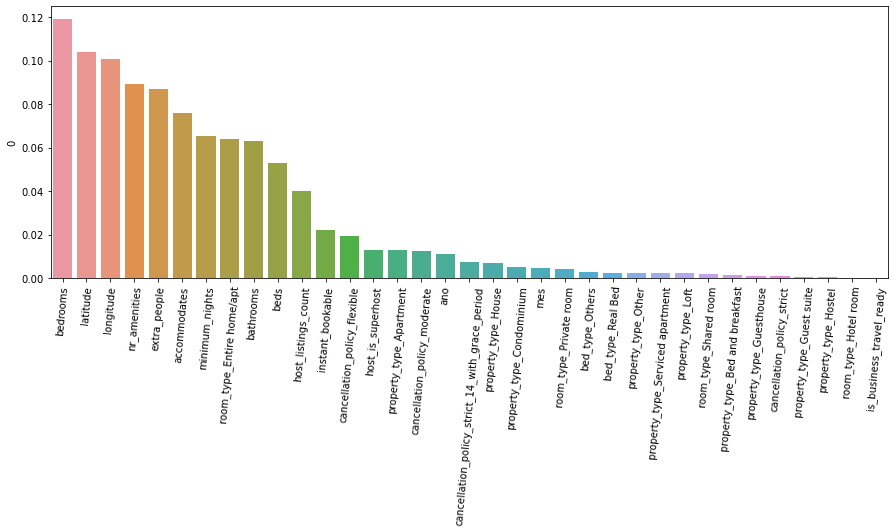

In [90]:
plt.figure(figsize = (15,5))
grafico = sns.barplot(feature_importance.index, feature_importance[0])
grafico.tick_params(axis= 'x', rotation = 85)

# Retirando colunas

In [92]:
base_airbnb_ajus_cod = base_airbnb_ajus.drop('is_business_travel_ready', axis = 1) 

In [94]:
# target
y = base_airbnb_ajus['price']
# features
X = base_airbnb_ajus.drop('price', axis = 1)

X_train, x_test, y_train, y_test = train_test_split(X, y, random_state = 10)

In [95]:
#train
m_extra_trees.fit(X_train, y_train)

#predict
previsao = m_extra_trees.predict(x_test)

#metrics
print(avaliar_modelo('extra_trees', y_test, previsao))

Modelo extra_trees
 R²: 97.49%
 RMSE: 42.00


# Deploy do projeto

* Passo 1 -> Criar arquivo do Modelo (joblib)
* Passo 2 -> Escolher a forma do deploy

    - Arquivo executável + Tkinter
    - Deploy em um Microsite (Flask)
    - Deploy apenas para uso direto (Streamlit)

* Passo 3 -> Outro arquivo Python (jupyter ou PyCharm)
* Passo 4 -> Importar streamlit e criar código
* Passo 5 -> Atribuir ao botão o carregamento do modelo
* Passo 6 -> Deploy feito



## Salvar modelo

In [99]:
joblib.dump(value = m_extra_trees, filename = r'../../PYTHON/HASHTAG/data/m_extra_trees.joblib')

['../../PYTHON/HASHTAG/data/m_extra_trees.joblib']